In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy
import pandas
from PIL import Image
import random
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Data/Output_Files_V6/'
Output_Diri = '/glade/u/home/whimkao//ExtraTrack/ExtraTrack_Github/RCP_Figs/Analysis_Figs_V6.5.2/'

In [3]:
# Open File
def Open_File(File):
    DF = pandas.read_csv(File)
    DF = DF.drop("Unnamed: 0", axis=1)
    return (DF)

In [4]:
# Open Each File
def Files_Open(Model, Diri, Dataset):
    Data_DF = Open_File(Diri+Model+'_Data_'+Dataset+'_Output_V6.csv')
    ET_DF = Open_File(Diri+Model+'_ET_'+Dataset+'_Output_V6.csv')
    Codes_DF = Open_File(Diri+Model+'_Codes_Output_V6.csv')
    Time, Begin_Time, Compl_Time, Peak_Time, Trop_Peak_Time = [], [], [], [], []
    Month, Trop_Month = [], []
# Edit Time Format
    for i in range(len(Data_DF)):
        Time.append(Datetime(Data_DF["Time(Z)"][i]))
        Month.append(Find_Month(Data_DF["Time(Z)"]))
    for j in range(len(ET_DF)):
        Begin_Time.append(Datetime(ET_DF["ET Begin Time"][j]))
        Compl_Time.append(Datetime(ET_DF["ET Complete Time"][j]))
        Trop_Peak_Time.append(Datetime(ET_DF["Trop Peak Time"][j]))
        Peak_Time.append(Datetime(ET_DF["Peak Time"][j]))
        Trop_Month.append(Find_Month(ET_DF["Trop Peak Time"]))
    Data_DF["Time(Z)"] = Time
    Data_DF["Month"] = Month
    ET_DF["ET Begin Time"] = Begin_Time
    ET_DF["ET Complete Time"] = Compl_Time
    ET_DF["Trop Peak Time"] = Trop_Peak_Time
    ET_DF["Peak Time"] = Peak_Time
    ET_DF["Month"] = Trop_Month
    return (Data_DF, ET_DF, Codes_DF)

In [5]:
def Datetime(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
    except:
        New_Time = numpy.nan
    return (New_Time)

In [6]:
def Find_Month(Time):
    try:
        New_Time = datetime.datetime.strptime(Time, '%Y-%m-%d %H:%M:%S')
        Month = New_Time.month
    except:
        Month = numpy.nan
    return (Month)

In [7]:
# Create Phase Distribution Bins
def Create_Bins(Min, Max, Bin_Width):
    Bins = numpy.arange(Min, Max+Bin_Width, Bin_Width)
    return (Bins)

In [8]:
Num_Years = numpy.array([90,93,93])

In [9]:
Control_Data, Control_ET, Control_Codes = Files_Open("Control", Diri)
RCP45_Data, RCP45_ET, RCP45_Codes = Files_Open("RCP45", Diri)
RCP85_Data, RCP85_ET, RCP85_Codes = Files_Open("RCP85", Diri)

In [13]:
# Create Function to Plot ET Histograms For Month
def ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Rela, Orient, Bins, \
    Dens_Min, Dens_Max, Dens_Width, Savefig, Figname):
    Fig = pyplot.figure(figsize=(12,8))
    Colours = ['limegreen', 'orange', 'red']
    Labels = ["Control", "RCP4.5", "RCP8.5"]
#
# Plot ET Initiation
    Axis = Fig.add_subplot(1,1,1)
    pyplot.hist([Control_Month, RCP45_Month, RCP85_Month], density=Rela, orientation=Orient, \
    bins=Bins, color=Colours, label=Labels)
    ET_Histo_Month_Formatting(Var, Var_Label, Rela, Orient, Dens_Min, Dens_Max, Dens_Width, "ET Initiation ")
#
# Legend
    pyplot.legend(loc=2, fontsize=15)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [15]:
# Formatting Based on Variable
def ET_Histo_Month_Formatting(Var, Var_Label, Rela, Orient, Dens_Min, Dens_Max, Dens_Width, Title1):
# Ticks and Lims
    if Orient == 'vertical':
        pyplot.xticks(Create_Bins(1,12,1))
        pyplot.xlim(0.5,12.5)
        pyplot.yticks(Create_Bins(Dens_Min, Dens_Max, Dens_Width))
        pyplot.ylim(Dens_Min, Dens_Max)
#
# Labels and Title
    if Rela == True:
        x_Label = "Proportion of Storms"
    else:
        x_Label = "Frequency of Storms"
    pyplot.ylabel(x_Label, fontsize=18)
    pyplot.xlabel(Var_Label, fontsize=18)
    Title = Title1 + Var
    pyplot.title(Title, fontsize=25)
#
# Gridlines
    pyplot.grid(linewidth=0.3, color='silver', linestyle='-')

In [16]:
# Define Bins
B_Bins = Create_Bins(-45,135,7.5)
VLT_Bins = Create_Bins(-600,600,50)

In [17]:
# Create Subsets
def Create_Subsets(Data, Subset_Var):
    if Subset_Var == "SLP(hPa)":
        Subset_1 = Data[Data[Subset_Var] > 1000].reset_index()
        Subset_2 = Data[(Data[Subset_Var] > 990) & (Data[Subset_Var] <= 1000)].reset_index()
        Subset_3 = Data[(Data[Subset_Var] > 980) & (Data[Subset_Var] <= 990)].reset_index()
        Subset_4 = Data[Data[Subset_Var] <= 980].reset_index()
        Subset_Labels = ["SLP > 1000hPa", "SLP 990~1000hPa", "SLP 980~990hPa", "SLP <= 980hPa"]
    elif Subset_Var == "Lat":
        Subset_4 = Data[Data[Subset_Var] < 30].reset_index()
        Subset_3 = Data[(Data[Subset_Var] >= 30) & (Data[Subset_Var] < 35)].reset_index()
        Subset_2 = Data[(Data[Subset_Var] >= 35) & (Data[Subset_Var] < 40)].reset_index()
        Subset_1 = Data[Data[Subset_Var] >= 40].reset_index()
        Subset_Labels = ["Lat >= 40N", "Lat 35~40N", "Lat 30~35N", "Lat < 30N"]
    Subsets = [Subset_1, Subset_2, Subset_3, Subset_4]
    return (Subsets, Subset_Labels)

In [18]:
# Create Function to Plot Phase Space Parameter Histograms
def Phase_Param_Histogram(Control_Data, RCP45_Data, RCP85_Data, Subset_Var, B_Bins, VLT_Bins, Savefig, Figname):
    Colours = ['limegreen', 'orange', 'red']
    Labels = ["Control", "RCP4.5", "RCP8.5"]
#
# Create Subsets
    Control_Subsets, Subset_Labels = Create_Subsets(Control_Data, Subset_Var)
    RCP45_Subsets, Subset_Labels = Create_Subsets(RCP45_Data, Subset_Var)
    RCP85_Subsets, Subset_Labels = Create_Subsets(RCP85_Data, Subset_Var)
#
# Create Axes
    Fig = pyplot.figure(figsize=(16,30))
    Axes = Fig.subplots(4,2, sharex=False, sharey=False)
    for i in range(4):
# Plot B
        Axes[i][0].hist([Control_Subsets[i]["B"], RCP45_Subsets[i]["B"], RCP85_Subsets[i]["B"]], density=True, \
        orientation='horizontal', bins=B_Bins, color=Colours, label=Labels)
        Axes[i][0].plot([0,1], [15,15], color='black', linewidth=1.8, linestyle='--')
        Param_Histo_Formatting(Axes, i, 0, "B", B_Bins, Subset_Var, Subset_Labels[i])
# Plot VLT
        Axes[i][1].hist([Control_Subsets[i]["VLT"], RCP45_Subsets[i]["VLT"], RCP85_Subsets[i]["VLT"]], density=True, \
        orientation='vertical', bins=VLT_Bins, color=Colours, label=Labels)
        Axes[i][1].plot([0,0], [0,1], color='black', linewidth=1.8, linestyle='--')
        Param_Histo_Formatting(Axes, i, 1, "VLT", VLT_Bins, Subset_Var, Subset_Labels[i])
# Legend
        if i == 0:
            Axes[i][0].legend(loc=1, fontsize=15)
#
# Save Fig
    Fig.tight_layout()
    if Savefig == True:
        Fig.savefig(Output_Diri+Figname, bbox_inches='tight')

In [19]:
# Formatting Based on Variable
def Param_Histo_Formatting(Axes, i, j, Var, Bins, Subset_Var, Subset_Label):
# Ticks and Lims
    if Var == "B":
        if Subset_Var == "SLP(hPa)":
            y_Min, y_Max, y_Width = -30, 75, 7.5
            x_Min, x_Max, x_Width = 0, 0.04, 0.005
        elif Subset_Var == "Lat":
            y_Min, y_Max, y_Width = -30, 90, 7.5
            x_Min, x_Max, x_Width = 0, 0.055, 0.005
    elif Var == "VLT":
        if Subset_Var == "SLP(hPa)":
            x_Min, x_Max, x_Width = -400, 400, 50
            y_Min, y_Max, y_Width = 0, 0.006, 0.0005
        elif Subset_Var == "Lat":
            x_Min, x_Max, x_Width = -400, 400, 50
            y_Min, y_Max, y_Width = 0, 0.005, 0.0005
    Axes[i][j].set_xticks(Create_Bins(x_Min, x_Max, x_Width))
    Axes[i][j].set_xlim(x_Min, x_Max)
    Axes[i][j].set_yticks(Create_Bins(y_Min, y_Max, y_Width))
    Axes[i][j].set_ylim(y_Min, y_Max)
#
# Labels and Title
    if j == 0:
        Axes[i][j].set_ylabel("B", fontsize=18)
        if i == 3:
            Axes[i][j].set_xlabel("Proportion of Datapoints", fontsize=18)
    elif j == 1:
        Axes[i][j].set_ylabel("Proportion of Datapoints", fontsize=18)
        if i == 3:
            Axes[i][j].set_xlabel("VLT", fontsize=18)
    Title = Var + ' (' + Subset_Label + ')'
    Axes[i][j].set_title(Title, fontsize=25)
#
# Gridlines
    Axes[i][j].grid(linewidth=0.5, color='silver', linestyle='-')

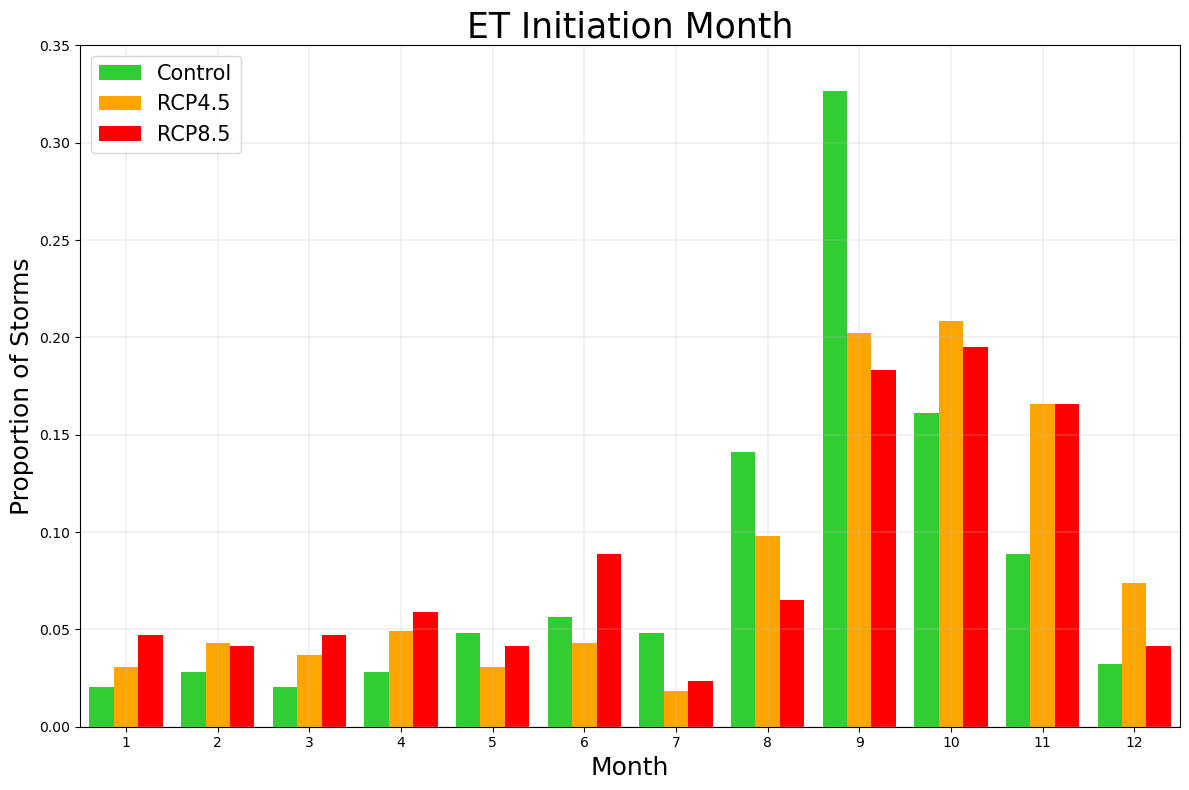

In [27]:
Var = "Month"
Var_Label = "Month"
Rela = True
Orient = 'vertical'
Bins = Create_Bins(0.5,12.5,1)
Dens_Min, Dens_Max, Dens_Width = 0, 0.35, 0.05
Savefig = True
Figname = 'ET_Month_Histo_Rela'
ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)

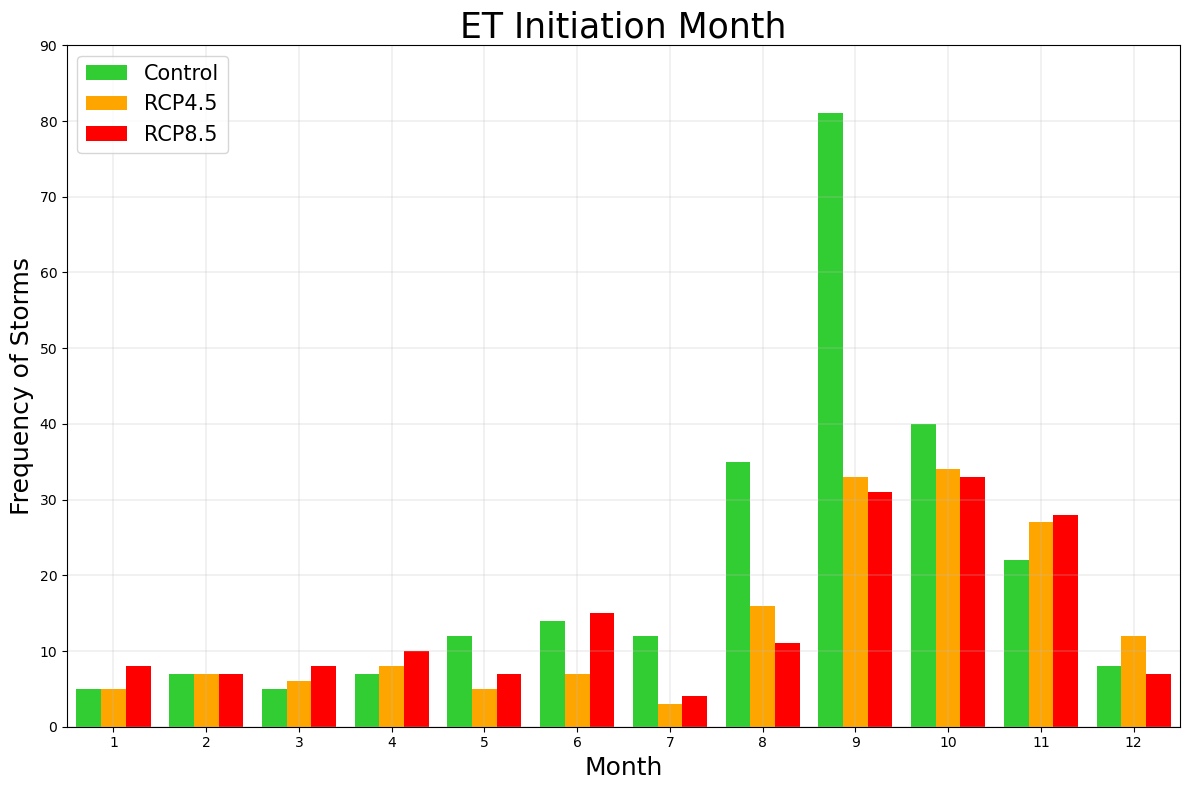

In [28]:
Var = "Month"
Var_Label = "Month"
Rela = False
Orient = 'vertical'
Bins = Create_Bins(0.5,12.5,1)
Dens_Min, Dens_Max, Dens_Width = 0, 90, 10
Savefig = True
Figname = 'ET_Month_Histo_Abs'
ET_Month_Histogram(Control_ET, RCP45_ET, RCP85_ET, Var, Var_Label, Rela, Orient, Bins, \
Dens_Min, Dens_Max, Dens_Width, Savefig, Figname)